# Phishing URL Detection

## Introduction

### Relevant Background Information

Phishing is a cybercrime that baits unknowing victims into clicking on URLs by acting like an authentic institution while contacting the victim through emails or other social media. Phishing is often used to steal user data, and with more and more of our data going online, the attack is becoming more and more vicious. Not only are phishing assaults dangerous to individuals, but they are also dangerous to huge corporations. For instance, one of the most extraordinary Phishing attacks includes the Colonial Pipeline scam, where over 3.4 billion euros were scammed out of the company. To counteract the dangers of phishing, our group will classify URLs as 'phishing' or 'legitimate' to warn victims before the attackers steal their sensitive information.

### Predictive Question

Can we classify an URL as phishing or legitimate?

### Dataset used to answer the Question

The dataset used in this project comes from: https://data.mendeley.com/datasets/c2gw7fy2j4/3/files/575316f4-ee1d-453e-a04f-7b950915b61b

The dataset is used by the article <a href="https://www.sciencedirect.com/science/article/pii/S0952197621001950#">Towards benchmark datasets for machine learning based website phishing detection: An experimental study</a> which can be found in the <a href="https://www.sciencedirect.com/journal/engineering-applications-of-artificial-intelligence">Engineering Applications of Artificial Intelligence journal</a>.

## Methods & Results

### Overview

To successfully classify an URL as phishing or legitimate, we will be using the K-Nearest Neighbors Classification Algorithm. To perform this algorithm successfully, we will use Forward Selection to choose the relevant predictors, use ```initial_split``` to split the data into training and testing sets, and use 5-fold cross-validation to choose the optimal ```K``` value. Finally, we will test our model on the testing set and analyze the results.

### Housekeeping

We start by loading the required libraries into R to allow us to perform data analysis.

In [518]:
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
require(gridExtra)

In [519]:
options(warn=-1) # Turn off warnings
options(dplyr.summarise.inform = FALSE) # Turn off summary() message

### Gathering Data

We use ```read_csv``` to read the data into R. (Notably, the CSV file is not hosted on data.mendeley.com; therefore, I am hosting the CSV file on my server.)

In [520]:
options(repr.matrix.max.rows = 5)
phishing_data <- read_csv("https://brianhan.tech/media/dsci/dataset_phishing.csv")

Rows: 11430 Columns: 89
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): url, status
dbl (87): length_url, length_hostname, ip, nb_dots, nb_hyphens, nb_at, nb_qm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Forward Selection

This dataset contains many predictors:

In [521]:
colnames(phishing_data)
ncol(phishing_data)

[1] "url"                        "length_url"                
 [3] "length_hostname"            "ip"                        
 [5] "nb_dots"                    "nb_hyphens"                
 [7] "nb_at"                      "nb_qm"                     
 [9] "nb_and"                     "nb_or"                     
[11] "nb_eq"                      "nb_underscore"             
[13] "nb_tilde"                   "nb_percent"                
[15] "nb_slash"                   "nb_star"                   
[17] "nb_colon"                   "nb_comma"                  
[19] "nb_semicolumn"              "nb_dollar"                 
[21] "nb_space"                   "nb_www"                    
[23] "nb_com"                     "nb_dslash"                 
[25] "http_in_path"               "https_token"               
[27] "ratio_digits_url"           "ratio_digits_host"         
[29] "punycode"                   "port"                      
[31] "tld_in_path"                "tld_in_subdomain"          
[33] "abnormal_subdomain"         "nb_subdomains"             
[35] "prefix_suffix"              "random_domain"             
[37] "shortening_service"         "path_extension"            
[39] "nb_redirection"             "nb_external_redirection"   
[41] "length_words_raw"           "char_repeat"               
[43] "shortest_words_raw"         "shortest_word_host"        
[45] "shortest_word_path"         "longest_words_raw"         
[47] "longest_word_host"          "longest_word_path"         
[49] "avg_words_raw"              "avg_word_host"             
[51] "avg_word_path"              "phish_hints"               
[53] "domain_in_brand"            "brand_in_subdomain"        
[55] "brand_in_path"              "suspecious_tld"            
[57] "statistical_report"         "nb_hyperlinks"             
[59] "ratio_intHyperlinks"        "ratio_extHyperlinks"       
[61] "ratio_nullHyperlinks"       "nb_extCSS"                 
[63] "ratio_intRedirection"       "ratio_extRedirection"      
[65] "ratio_intErrors"            "ratio_extErrors"           
[67] "login_form"                 "external_favicon"          
[69] "links_in_tags"              "submit_email"              
[71] "ratio_intMedia"             "ratio_extMedia"            
[73] "sfh"                        "iframe"                    
[75] "popup_window"               "safe_anchor"               
[77] "onmouseover"                "right_clic"                
[79] "empty_title"                "domain_in_title"           
[81] "domain_with_copyright"      "whois_registered_domain"   
[83] "domain_registration_length" "domain_age"                
[85] "web_traffic"                "dns_record"                
[87] "google_index"               "page_rank"                 
[89] "status"

[1] 89

Notably, many predictors are not attainable through the URL alone. For instance, we cannot know the ```google_index``` through the URL alone (we would need another service). To answer the question: "Can we classify an URL as phishing or legitimate?" we will only select the predictors that can be directly obtained from the URL.

After filtering for predictors that are directly obtained from the URL, we will select the ones that we find necessary (Note: Ideally, we will perform forward selection on all of these variables; however, that would take way too long).

In [522]:
phishing_subset <- phishing_data |>
                   select(status, length_url, length_hostname, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde,
                          nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, http_in_path, https_token, 
                          ratio_digits_url, ratio_digits_host, nb_subdomains,longest_word_host, longest_word_path, avg_words_raw, avg_word_host, 
                          domain_registration_length)
ncol(phishing_subset)

[1] 30

After slimming down the dataset to 30 columns, we will perform Forward Selection. Credit for the code goes to <a href="https://datasciencebook.ca/classification2.html#forward-selection-in-r">datasciencebook.ca, Classification II: evaluation & tuning, 6.8.3 Forward Selection in R</a>.

```r
phishing_subset <- phishing_data |>
                   select(status, length_url, length_hostname, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde,
                          nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, http_in_path, https_token, 
                          ratio_digits_url, ratio_digits_host, nb_subdomains,longest_word_host, longest_word_path, avg_words_raw, avg_word_host, 
                          domain_registration_length) %>%
                   mutate(https_token = as_factor(https_token))

names <- colnames(phishing_subset |> select(-status))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
phishing_vfold <- vfold_cv(phishing_subset, v = 5, strata = status)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("status", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        phishing_recipe <- recipe(as.formula(model_string), 
                                  data = phishing_subset) |>
                          step_scale(all_numeric_predictors()) |>
                          step_center(all_numeric_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
               add_recipe(phishing_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = phishing_vfold, grid = 10) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
```

As the code takes a long time to run, we have not included it in this file. The running of the code can be seen in the (attached) ```Topic Proposal.ipynb``` file, and we will load the results from the ```accuracies.csv``` file.

In [523]:
accuracies <- read_csv("https://brianhan.tech/media/dsci/accuracies.csv")
print("Table 1: Forward Selection Results")
head(accuracies, 2)

Rows: 29 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model_string
dbl (2): size, accuracy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Forward Selection Results"


size,model_string,accuracy
<dbl>,<chr>,<dbl>
1,status ~ longest_word_path,0.6675416
2,status ~ longest_word_path+domain_registration_length,0.7453193


By organizing the output from forward selection, we would find the most useful predictors in classifying an URL as phishing or legitimate.

In [524]:
accuracies <- accuracies %>%
              arrange(desc(accuracy))
print("Table 2: Arranged Forward Selection Results (in descending order of accuracy)")
head(accuracies, 4)

[1] "Table 2: Arranged Forward Selection Results (in descending order of accuracy)"


size,model_string,accuracy
<dbl>,<chr>,<dbl>
16,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde,0.8597550
17,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or,0.8597550
18,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or+nb_dollar,0.8596675
19,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or+nb_dollar+nb_star,0.8596675


Notably, there is a tie for the highest accuracy of 0.8597550. We chose to have fewer predictors (16) to decrease the number of computations our model requires (multicollinearity does not apply to Knn Neighbors).

### Clean Up and Splitting the Data

Now, we will clean up our data set by only selecting the relevant variables we found in the forward selection algorithm.

In [525]:
cleaned_phishing_data <- phishing_data %>%
                         select(status, longest_word_path, domain_registration_length, nb_hyphens, nb_slash, nb_dots, ratio_digits_url,
                                length_hostname, avg_word_host, longest_word_host, length_url, nb_underscore, nb_at, ratio_digits_host, http_in_path,
                                nb_semicolumn, nb_tilde) %>%
                         mutate(status = as_factor(status))

We will also be omitting any rows that have blanks in them.

In [526]:
cleaned_phishing_data <- na.omit(cleaned_phishing_data)

As our table is now cleaned (the original dataset was already very clean), we can continue by splitting the data into training and testing sets. We will use a proportion of 75% of the data for training and 25% of the data for testing. Because ```initial_split``` uses randomization, we will set a seed to ensure that the results are reproducible.

In [527]:
set.seed(0717)
cleaned_phishing_data_split <- initial_split(cleaned_phishing_data, prop = 3/4, strata = status)
phishing_train <- training(cleaned_phishing_data_split)
phishing_test <- testing(cleaned_phishing_data_split)

### Sanity Check for Chosen Variables (Exploring Data)

As we have 16 different predictors, we will only be doing sanity checks on three predictors, ```longest_word_path```, ```nb_slash```, and ```nb_hyphens```.

#### Predictor 1 ```longest_word_path```

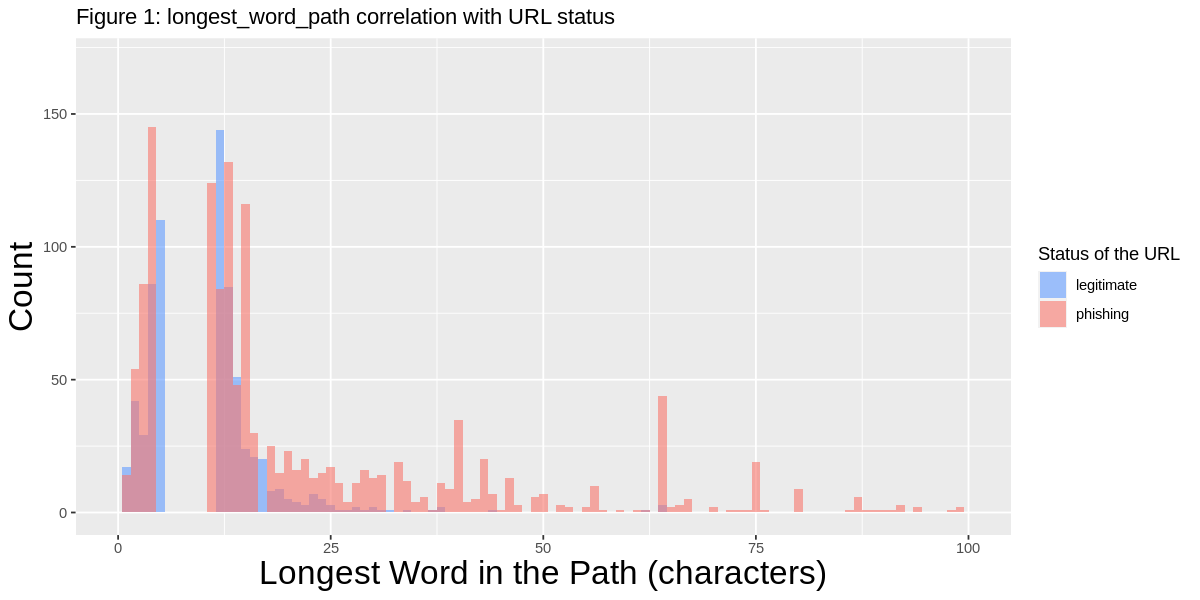

In [528]:
options(repr.plot.width = 10, repr.plot.height = 5) 
longest_word_path_plot  <- phishing_train %>%
                           select(status, longest_word_path) %>%
                           group_by(longest_word_path, status) %>%
                           dplyr::summarize(n = n()) %>%
                           ggplot(aes(x = longest_word_path, y = n, fill = status)) +
                               geom_bar(stat = "identity", position = "identity", width = 1, alpha = 0.6) +
                               xlim(0, 100) +
                               ylim(0, 170) +
                               labs(x = "Longest Word in the Path (characters)", y = "Count", fill = "Status of the URL") +
                               ggtitle("Figure 1: longest_word_path correlation with URL status") +
                               scale_fill_manual("Status of the URL", values = c("legitimate" = "#619CFF", "phishing" = "#F8766D")) +
                               theme(axis.title = element_text(size = 20))

longest_word_path_plot

The longest word in path tells us, the longest word in the URL path. For instance, ```<some-url>/ap/89e6a3b4b063b8d/?cmd=update&dispatch=89e6a3b4b063b8d1b&locale=```, has a character count of 17, with the longest word in path being: ```89e6a3b4b063b8d1b```.

The figure above shows that the ```longest_word_path``` predictor ***does*** help with predicting the status of the URL. The graph shows that phishing URLs (in general) have a longer word in the URL path than legitimate URLs, meaning this predictor can reliably classify URLs as legitimate or phishing.

#### Predictor 2 ```nb_slash```

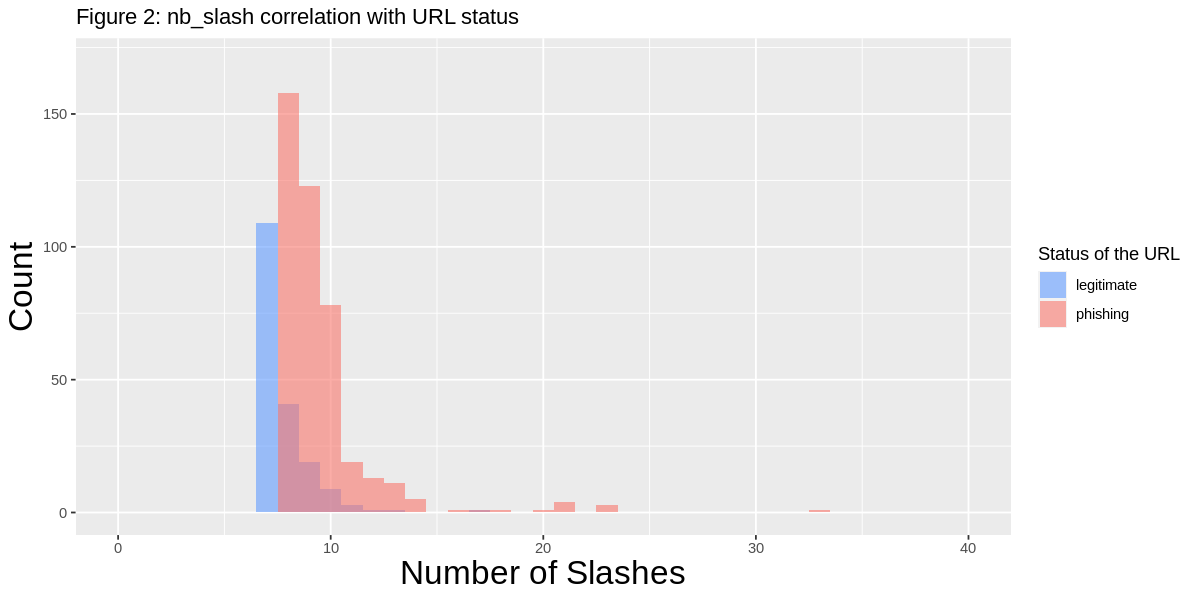

In [529]:
options(repr.plot.width = 10, repr.plot.height = 5) 
nb_slash_plot  <- phishing_train %>%
                  select(status, nb_slash) %>%
                  group_by(nb_slash, status) %>%
                  dplyr::summarize(n = n()) %>%
                  ggplot(aes(x = nb_slash, y = n, fill = status)) +
                      geom_bar(stat = "identity", position = "identity", width = 1, alpha = 0.6) +
                      xlim(0, 40) +
                      ylim(0, 170) +
                      labs(x = "Number of Slashes", y = "Count", fill = "Status of the URL") +
                      ggtitle("Figure 2: nb_slash correlation with URL status") +
                      scale_fill_manual("Status of the URL", values = c("legitimate" = "#619CFF", "phishing" = "#F8766D")) +
                      theme(axis.title = element_text(size = 20))

domain_registration_length_plot

The graph shows that the peak (most data points with the same number of slashes) differs between legitimate and phishing URLs. This difference can be used to differentiate between legitimate/phishing URLs, hence, helping our classification algorithm.

#### Predictor 3 ```nb_hyphens``` (Number of Hyphens)

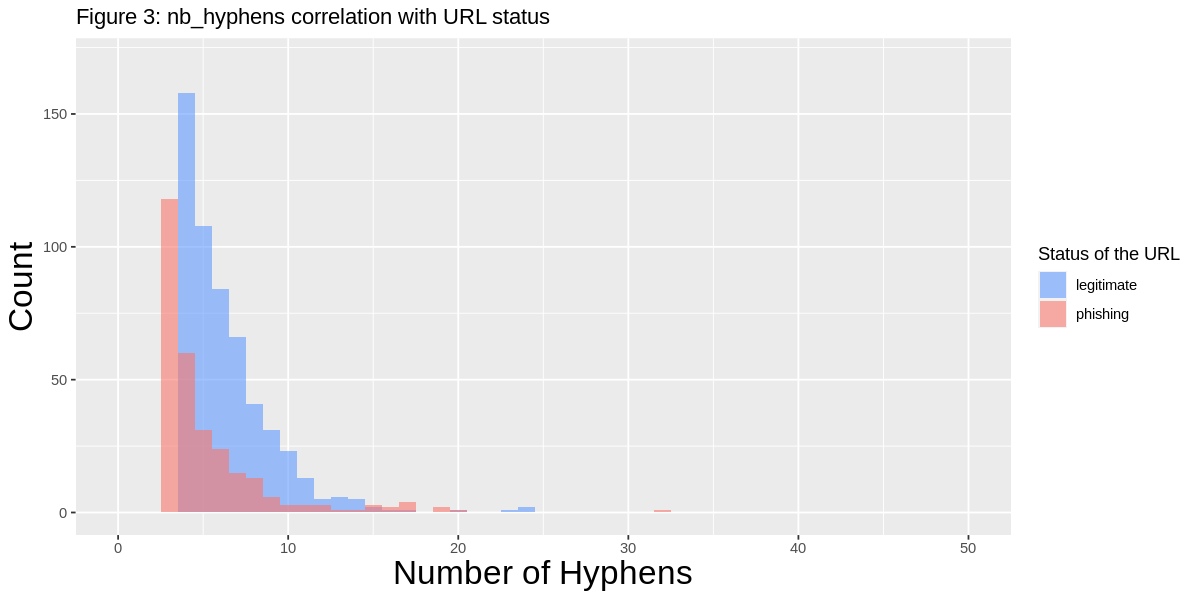

In [530]:
options(repr.plot.width = 10, repr.plot.height = 5) 
nb_hyphens_plot  <- phishing_train %>%
                    select(status, nb_hyphens) %>%
                    group_by(nb_hyphens, status) %>%
                    dplyr::summarize(n = n()) %>%
                    ggplot(aes(x = nb_hyphens, y = n, fill = status)) +
                        geom_bar(stat = "identity", position = "identity", width = 1, alpha = 0.6) +
                        xlim(0, 50) +
                        ylim(0, 170) +
                        labs(x = "Number of Hyphens", y = "Count", fill = "Status of the URL") +
                        ggtitle("Figure 3: nb_hyphens correlation with URL status") +
                        scale_fill_manual("Status of the URL", values = c("legitimate" = "#619CFF", "phishing" = "#F8766D")) +
                        theme(axis.title = element_text(size = 20))

nb_hyphens_plot

The graph shows that the peak (most data points with the same number of hyphens) differs between legitimate and phishing URLs. This difference can be used to differentiate between legitimate/phishing URLs, hence, helping our classification algorithm.

### Checking for imbalance (exploring the training data)

To check for data imbalance, we will create a bar graph to compare the number of legitimate URLs with the number of phishing URLs in our training data.

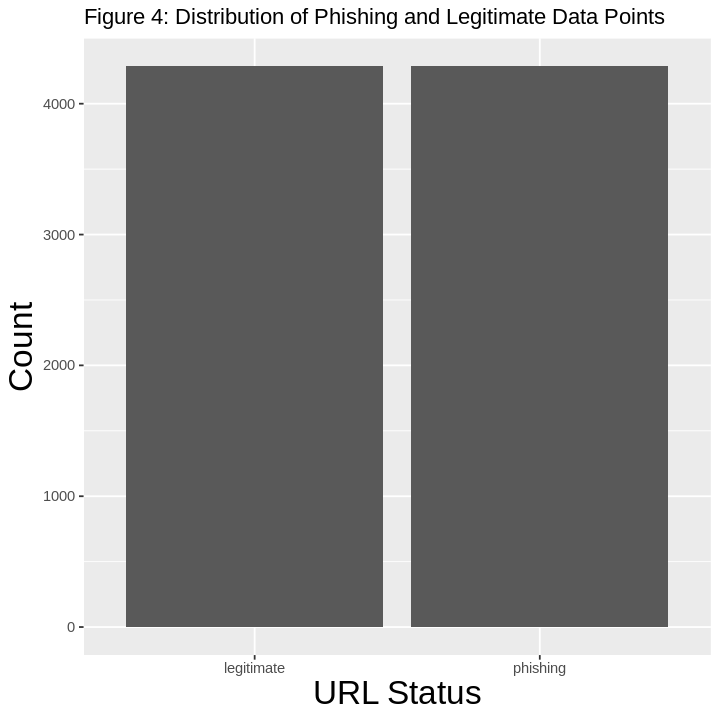

In [531]:
options(repr.plot.width = 6, repr.plot.height = 6) 

phishing_status_count <- phishing_train %>%
                         select(status) %>%
                         group_by(status) %>%
                         dplyr::summarize(n = n())

phishing_data_exploration <- phishing_status_count %>%
                             ggplot(aes(x = status, y = n)) +
                                 geom_bar(stat = "identity") +
                                 labs(x = "URL Status", y = "Count") +
                                 theme(axis.title = element_text(size = 20)) +
                                 ggtitle("Figure 4: Distribution of Phishing and Legitimate Data Points")

phishing_data_exploration

As our bar graph shows, the phishing and legitimate URL bars are equal in height, ensuring that our training data is balanced.

### Using 5-Fold Cross-Validation to get the Optimal Value of K (number of nearest neighbors)

Continuing, we will scale our data to prevent features that have larger scales from overly influencing the distance measure used in Knn Classification.

In [532]:
phishing_recipe <- recipe(status ~ ., data = phishing_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())

Then, we use ```vfold_cv``` to split our training data into five folds, and because vfold uses randomization, we will set a seed to ensure that the result is reproducible.

In [533]:
set.seed(931)
phishing_vfold <- vfold_cv(phishing_train, v = 5, strata = status)

Using ```tune()```, R allows us to specify that we want to tune the parameter ```neighbors```.

In [534]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

We set the values of ```K``` we want to test using ```seq()```.

In [535]:
k_vals <- tibble(neighbors = seq(from = 1, to = 5, by = 1))

Finally, we create a ```workflow``` to find the optimal value of ```K``` using the ```recipe```, ```model```, and ```cross-validation``` settings we created above.

In [536]:
knn_results <- workflow() %>%
               add_recipe(phishing_recipe) %>%
               add_model(knn_spec) %>%
               tune_grid(resamples = phishing_vfold, grid = k_vals) %>%
               collect_metrics()

By creating a neighbors vs. accuracy estimate plot, we can find the optimal value of ```K```.

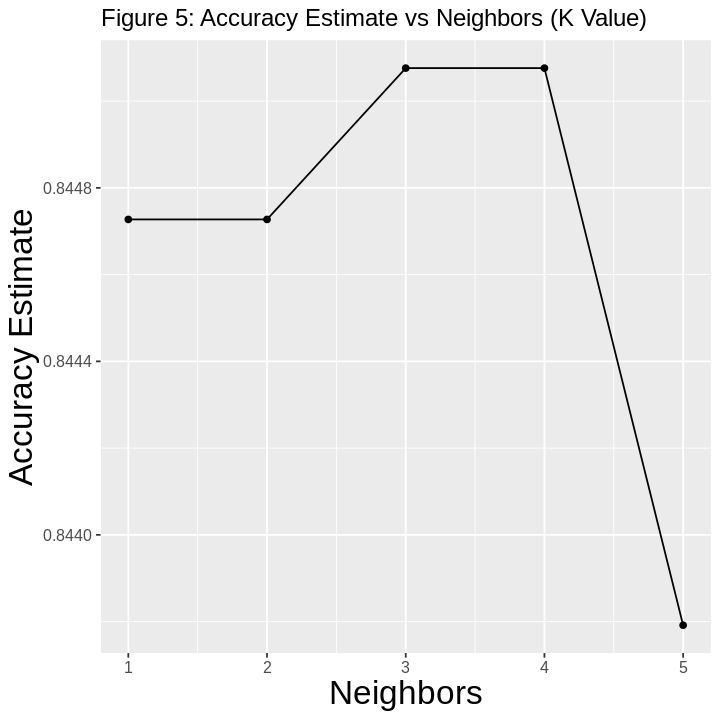

In [537]:
options(repr.plot.width = 6, repr.plot.height = 6)

k_accuracies <- knn_results |>
                filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(k_accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") + 
                     theme(axis.title = element_text(size = 20),
                           text = element_text(size = 12)) +
                     ggtitle("Figure 5: Accuracy Estimate vs Neighbors (K Value)")

accuracy_vs_k

Looking at the graph, we can conclude that ```K``` equals 3 or 4. In fear of overfitting the model, we chose ```K = 4```.

*Notably, we tried K from 1 to 100; however, as it would take too long to compute, we watered it down for the project report.*

### Creating the Actual Model

Now that we have organized the data and found the optimal value of ```K```, we can start creating the actual model.

We start by creating a new model specification. This time, we will use the optimal value of ```K``` we found through ```cross-validation``` instead of ```tune()```.

In [538]:
actual_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
                   set_engine("kknn") %>%
                   set_mode("classification")

Then, we will create a new workflow, fitted for the model, by utilizing the recipe we had built in the cross-validation step and the new model specification we built above.

In [539]:
knn_fit <- workflow() %>%
           add_recipe(phishing_recipe) %>%
           add_model(actual_knn_spec) %>%
           fit(data = phishing_train)

### Testing the model and Analysis

To understand how well our model performs, we will be testing the model by using ```predict()``` and the testing data we have set up during ‘Clean Up and Splitting the Data.’ We also use ```bind_cols()``` to have the predicted and actual values in the same dataframe.

In [540]:
knn_predict <- knn_fit %>%
               predict(phishing_test) %>%
               bind_cols(phishing_test)

To see how well the model performs, we will get our model's accuracy by filtering ```.metric``` and selecting the ```.estimate``` column.

In [541]:
knn_accuracy <- knn_predict %>%
                metrics(truth = status, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

print("Table 3: Accuracy estimate")
knn_accuracy

[1] "Table 3: Accuracy estimate"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8607418


The estimated accuracy tells us that our model predicts the correct status of the URL 86% of the time.

We will create a confusion matrix to understand better what this '86%' implies.

In [542]:
# Create Confusion matrix
confusion_matrix <- knn_predict %>%
                    conf_mat(truth = status, estimate = .pred_class)

print("Table 4: Confusion Matrix")
confusion_matrix

[1] "Table 4: Confusion Matrix"


            Truth
Prediction   legitimate phishing
  legitimate       1255      224
  phishing          174     1205

***Notably****, our confusion matrix is 'flipped.' We are predicting for 'phishing,' so our True Positive value will be when ```Truth = phishing``` and ```Prediction = phishing```.*

To visually interpret the confusion matrix, we created visuals showing the distribution of right and wrong predictions.

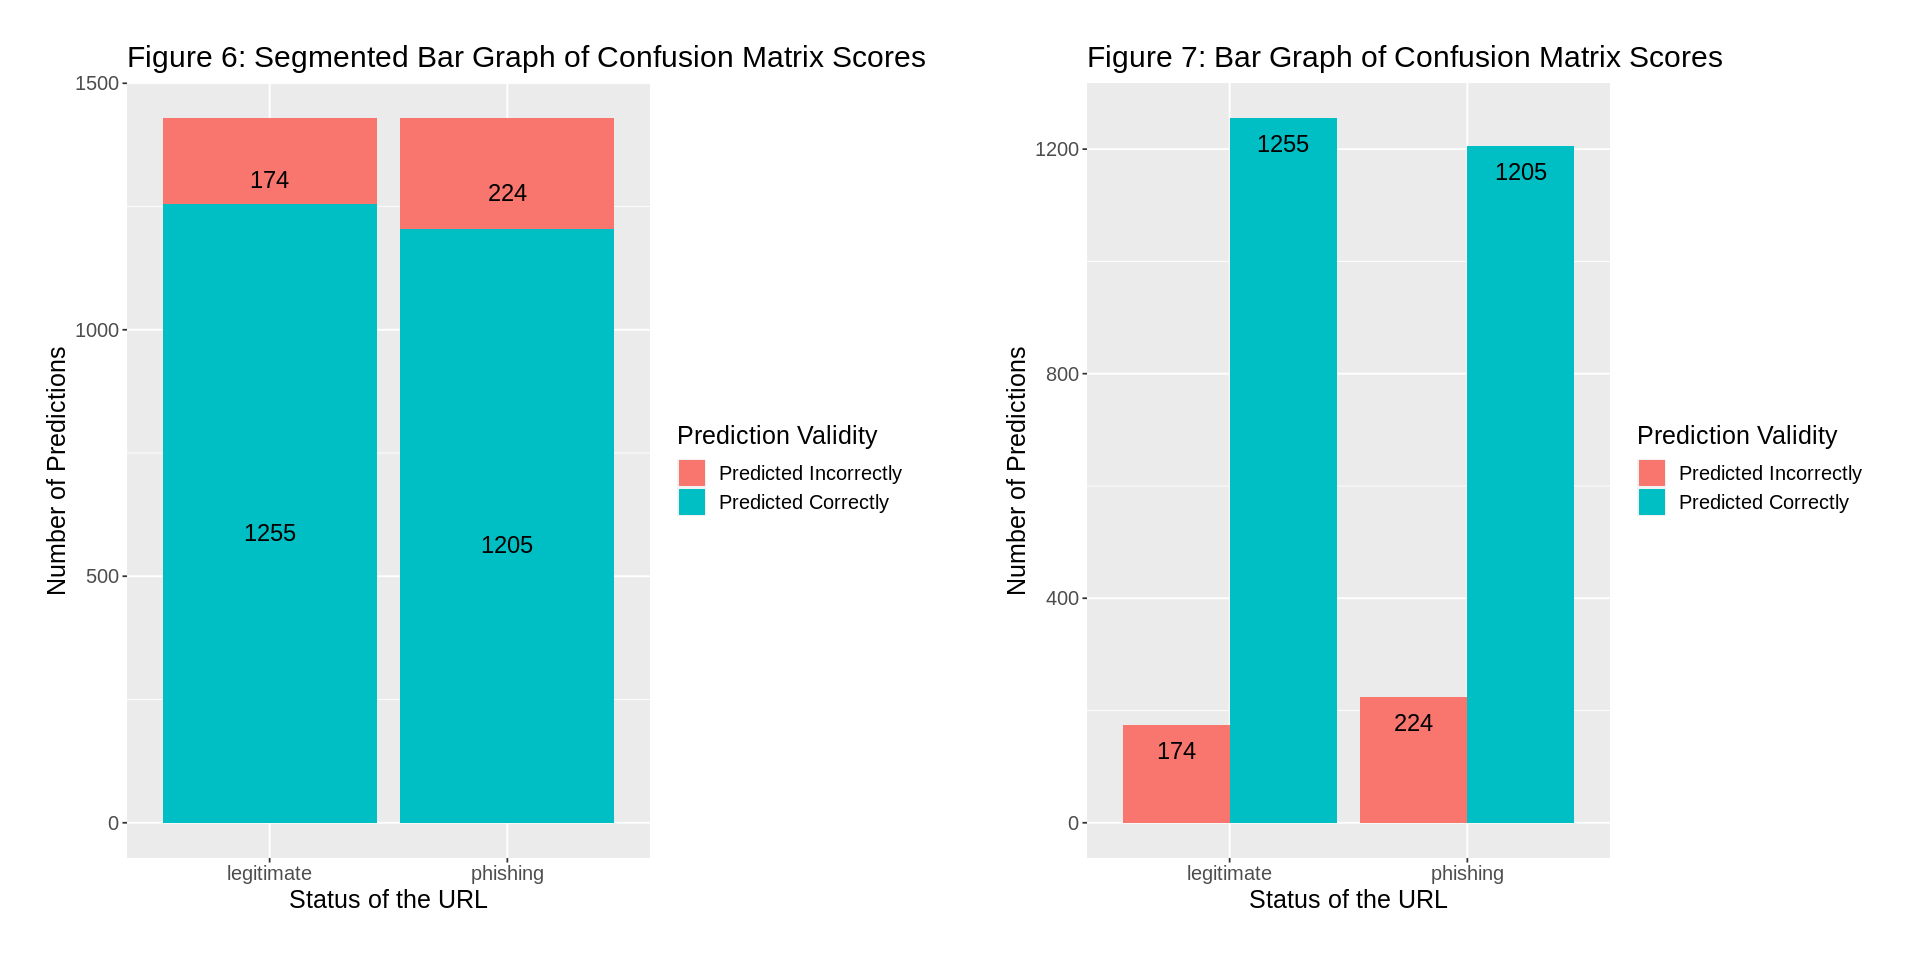

In [543]:
options(repr.plot.width = 16, repr.plot.height = 8) 

# Adding column for Prediction != Truth, then it is wrong.
confusion_matrix_tibble <- confusion_matrix$table %>%
                           as_tibble() %>%
                           add_column(validity = c("Predicted Correctly", 
                                                   "Predicted Incorrectly", 
                                                   "Predicted Incorrectly", 
                                                   "Predicted Correctly"))

# Reordered tibble
confusion_matrix_tibble <- confusion_matrix_tibble[c(1,2,4,3), ]

# Arranged column "W' and "C" to display properly on segmented bar graph.
confusion_matrix_tibble$validity <- factor(confusion_matrix_tibble$validity, 
                                           levels = c("Predicted Incorrectly", 
                                                      "Predicted Correctly"))

# Getting position for y-axis label
confusion_matrix_cumsum <- ddply(confusion_matrix_tibble, 
                                 "Truth", 
                                 transform, 
                                 label_ypos=cumsum(n) - 0.5*n)

# Create segmented bar graph
confusion_matrix_segmented_bar_graph <- confusion_matrix_cumsum %>%
                                        ggplot(aes(x = Truth, y = n, fill = validity)) +
                                            geom_bar(stat = "identity") + 
                                            geom_text(aes(y=label_ypos, label = n), 
                                                      vjust = 1.6, 
                                                      size=5) +
                                            labs(x = "Status of the URL", 
                                                 y = "Number of Predictions", 
                                                 fill = "Prediction Validity") +
                                            ggtitle("Figure 6: Segmented Bar Graph of Confusion Matrix Scores") +
                                            theme(
                                                  axis.title = element_text(size = 15),
                                                  text = element_text(size = 15),
                                                  plot.margin = unit(c(1,1,1,1), "cm"))
                                         

# Create Bar Graph
confusion_matrix_bar_graph <- confusion_matrix_tibble %>%
                              ggplot(aes(x = Truth, y = n, fill = validity)) +
                                  geom_bar(stat = "identity", position = "dodge") +
                                  geom_text(aes(label = n), vjust = 2, 
                                            position = position_dodge(0.9), size=5) +
                                  labs(x = "Status of the URL", 
                                       y = "Number of Predictions", 
                                       fill = "Prediction Validity") +
                                  ggtitle("Figure 7: Bar Graph of Confusion Matrix Scores") +
                                  theme(axis.title = element_text(size = 15),
                                        text = element_text(size = 15),
                                        plot.margin = unit(c(1,1,1,1), "cm"))

# arrange grid
grid.arrange(confusion_matrix_segmented_bar_graph, confusion_matrix_bar_graph, ncol = 2)

The confusion matrix and its subsequent visualizations tell us the distribution of correct/incorrect predictions created by our model. Out of the 2858 data points in our test data, our model predicted 2473 points correctly and 385 points incorrectly. The incorrect predictions include 176 legitimate URLs classified as phishing (False Positive) and 227 phishing URLs classified as legitimate (False Negative). *Remember that our confusion matrix is flipped.*

Our model predicts False Negatives a lot more than False Positives. A False Negative classification can mean a user losing their data and identity stolen. In contrast, a False Positive could warn the user about a malicious URL. Clearly, False Negatives have a lot more dire consequences than False Positives; therefore, this should be addressed in future iterations.

## Discussion

**Findings**

We have created a model with an 86% accuracy in detecting whether an URL is phishing or legitimate. We accomplished this by finding a data set on data.mendeley.com, then performing Forward Selection on the whole data set. After finding the appropriate predictors, we cleaned the data and used ```initial_split``` to put the data into a training and testing set. Using the training set, we checked our predictors for correlation (Figures 1, 2, and 3) and imbalance (Figure 4). Since our predictors made sense and there was no data imbalance, we continued by doing 5-fold cross-validation. By plotting the Accuracy Estimate vs. Neighbors (Figure 5), we found the optimal number of neighbors, K = 4. Finally, we built our Knn Classification model and tested it against our training set.

Though our model is quite accurate, we also found that our model predicts False Negatives more than False Positives (Figures 6 and 7). This should be addressed in future iterations of the model, as False Negatives have more dire consequences than False Positives.

**Expectations**

We *did* expect to be able to create a classification model that can classify phishing/legitimate URLs with high accuracy. This is because phishing detection has been thoroughly researched since the birth of the cyberattack. So, by using a dataset that contained a plethora of essential predictors, which is found in the article, <a href="https://www.sciencedirect.com/science/article/pii/S0952197621001950#">Towards benchmark datasets for machine learning based website phishing detection: An experimental study</a>, and performing well-documented algorithms such as Forward Selection, Cross-Validation, and KNN Classification, we had high confidence that our model would be able to classify whether an URL is phishing/legitimate with high accuracy.

**Impact**

As shown in our accuracy estimate and confusion matrix, it is possible to do phishing detection with only 16 variables, and the vast amount of variables initially included in the original data set has gone unused. This means we have created a phishing URL detection model requiring fewer predictors and, subsequently, fewer computations than expected. Decreasing the number of computations means increasing the speed of detecting phishing URLs, allowing us to prevent bad actors from stealing one's information.

**Future Questions**

This project leads to future questions like
- What percentage of phishing is prevented by your email service?
- Would phishing URLs advance to the point that they will be undetectable?
- What new types of phishing attacks come to play in the future?
- Can the power of quantum computing increase the lethality of phishing URLs? Moreover, can quantum computing be used to increase the accuracy or speed in classifying phishing/legitimate URLs?


## Works Cited

- Hannousse, A., & Yahiouche, S. (2021). Towards benchmark datasets for machine learning based website phishing detection: An experimental study. Engineering Applications of Artificial Intelligence, 104(104), 104347. https://doi.org/10.1016/j.engappai.2021.104347
- Mercedes Cardona. (2021, September 24). What is URL Phishing? Mimecast. https://www.mimecast.com/blog/what-is-url-phishing/
- Peng, T. T., Trevor Campbell, and Melissa Lee Foreword by Roger. (2022). Data Science. In datasciencebook.ca. Chapman & Hall. https://datasciencebook.ca/
- Sarang Narkhede. (2018, May 9). Understanding Confusion Matrix. Medium; Towards Data Science. https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
- Schneider, J. (2019). Cross Validation. Cmu.edu. https://www.cs.cmu.edu/~schneide/tut5/node42.html